# Lilbraries & functions

In [1]:
import numpy as np
import pandas as pd
import pyBigWig as bw

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

import threading
print(threading.active_count(), 'threads active at start')
from multiprocessing import Pool
from functools import partial


%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from KalmanFilter import KalmanFilter, KalmanFilter_k_hidden

# vectorized version
def hsv_to_rgb_v( h, s, v) -> tuple:
    
    out = np.full([h.shape[0],3], np.nan)
    idx_na = np.isnan(h) | np.isnan(s) | np.isnan(v)
    out[idx_na,:] = np.array([1,1,1]).T

    out_tmp = np.full([np.sum(~idx_na),3], np.nan)
    h = h[~idx_na]
    s = s[~idx_na]
    v = v[~idx_na]

    h[h==1.0] = 0.0
    i = (h*6.0).astype(int)
    f = h*6.0 - i
        
    w = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i[s==0] = -1

    out_tmp[i==0,:] = np.array([v[i==0],t[i==0],w[i==0]]).T
    out_tmp[i==1,:] = np.array([q[i==1],v[i==1],w[i==1]]).T
    out_tmp[i==2,:] = np.array([w[i==2],v[i==2],t[i==2]]).T
    out_tmp[i==3,:] = np.array([w[i==3],q[i==3],v[i==3]]).T
    out_tmp[i==4,:] = np.array([t[i==4],w[i==4],v[i==4]]).T
    out_tmp[i==5,:] = np.array([v[i==5],w[i==5],q[i==5]]).T
    out_tmp[i==-1,:] = np.array([v[i==-1],v[i==-1],v[i==-1]]).T

    out[~idx_na,:] = out_tmp

    
    return out

7 threads active at start


# Toy example

loglik =  -3006.0472649683074


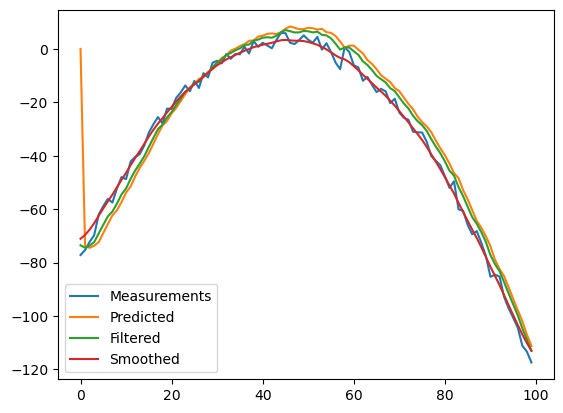

In [4]:
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

kf = KalmanFilter(F = F, H = H, Q = Q, R = R, μ_0 = np.array([0,0,0]), Σ_0 = np.eye(3)*10)

predicted = []
filtered = []
for z in measurements:
    predicted.append(np.dot(H,  kf.predict()[0]))
    filtered.append(np.dot(H,  kf.update(z)[0]))

plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predicted)), np.array(predicted), label = 'Predicted')
plt.plot(range(len(filtered)), np.array(filtered), label = 'Filtered')

#test Forward-Backward
forward_table, ll = kf.fullForward(measurements)
print('loglik = ', ll)

smoothed = kf.Backward(forward_table,F)[0]
s=(H[:,None,:] * np.array(smoothed)[None,:,:]).sum(axis=2).squeeze()
plt.plot(range(len(measurements)), s, label = 'Smoothed')
plt.legend()
plt.show()


# PROseq

## Get dataset

## Kalman filtering and smoothing

### Plots and functions

In [25]:
def get_data(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}

    [chr,start,end,strand] = coord.split(':')

    # Load bigWigs
    bw_files = {}
    for t in T:
        sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        bw_files[t] = bw.open(fin)

    # get data
    df = pd.DataFrame(columns=['start','end'])
    for t in T:
        df_t = pd.DataFrame(bw_files[t].intervals(chr,int(start),int(end)),columns=['start','end',f"{t}"])
        #df_t.columns = ['start','end',f"{t}"]
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df.sort_values('start',inplace=True)
    df.reset_index(inplace=True,drop=True)

    # replace start and end with position in the middle of the bin, and set as index
    df['start'] = ( (df.start.values + df.end.values)/2 ).astype(int) # bp
    df.drop('end',axis=1,inplace=True)
    df.columns = ['pos'] + df.columns[1:].tolist()
    df.set_index('pos',inplace=True)

    # fill missing values with 0
    df.fillna(0,inplace=True)

    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log(x+1/bin_size),axis=1)
    

    return df

def plot_log_likelihood(LL,K,fname):
    
    # find the maximum
    x_max = LL.argmax()
    y_max = LL.max()
    k_max = K[x_max]
    v_max = 2*np.pi/(24*3600*k_max)
    
    fig, axes = plt.subplots(1,2,figsize=(6,2),sharey=True,gridspec_kw={'wspace':0.01},tight_layout=True)

    ax = axes[0]
    ax.plot(-K[K<0],np.exp(LL[K<0]-max(LL)),'k.-')
    #ax.plot(-K[K<0],np.exp(LL[K<0]),'k.-')
    if K[x_max] < 0:
        ax.plot(-K[x_max],np.exp(y_max-max(LL)),'r.')
        #ax.plot(-K[x_max],np.exp(y_max),'r.')

    #zero = ax.get_xlim()[0]
    #ax.plot(0,np.exp(LL[K==0]-max(LL)),'o',color='k')

    # inverse x axis
    ax.invert_xaxis()
    ax.set_xlabel(r'k')
    ax.set_ylabel('likelihood')
    ax.set_title(rf'max likelihood at $k={k_max*1e6:.2f}[rad/Mb]$')
    ax.set_xscale('log')
    
    x_ticklabels = ax.get_xticklabels()
    for i in range(len(x_ticklabels)):
        new_text = x_ticklabels[i].get_text().replace('10','-10')
        x_ticklabels[i].set_text(new_text)
    ax.set_xticklabels(x_ticklabels)

    ax = axes[1]
    ax.plot(K[K>0],np.exp(LL[K>0]-max(LL)),'k.-')
    #ax.plot(K[K>0],np.exp(LL[K>0]),'k.-')
    if K[x_max] > 0:
        ax.plot(K[x_max],np.exp(y_max-max(LL)),'r.')
        #ax.plot(K[x_max],np.exp(y_max),'r.')
    
    zero = 8e-8
    ax.plot(zero,np.exp(LL[K==0]),'.',color='gray')

    yticklabels = ax.get_yticklabels()
    ax.set_yticklabels([f'-{y}' for y in yticklabels])
    ax.set_xlabel(r'k')
    ax.set_title(rf'$v={v_max:.2f}[bp/sec]$')
    ax.set_xscale('log')
    
    fig.savefig(fname)
    #fig.subplots_adjust(wspace=0)

def plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf,fname):
    # put phi_kf - phi_n between -pi and pi
    idx_tl = (φ_kf - φ_n) > np.pi
    idx_br = (φ_n - φ_kf) > np.pi
    idx_tr = (φ_n + φ_kf) > 2*np.pi
    idx_bl = (φ_n + φ_kf) < 2*np.pi
    φ_n[idx_tl & idx_bl] += 2*np.pi
    φ_kf[idx_tl & idx_tr] -= 2*np.pi
    φ_kf[idx_br & idx_bl] += 2*np.pi
    φ_n[idx_br & idx_tr] -= 2*np.pi

    alpha = a_kf/a_kf.mean()
    alpha[alpha>1] = 1

    fig = plt.figure(figsize=(3,3))
    plt.subplot(111)
    plt.plot([0,2*np.pi],[0,2*np.pi],'k--',lw=1)
    plt.scatter(φ_n,φ_kf,s=3,marker='.',alpha=alpha)
    plt.xlabel('φ_n')
    plt.ylabel('φ_kf')
    fig.tight_layout()
    fig.savefig(fname[0])

    fig = plt.figure(figsize=(2,2))
    plt.subplot(111)
    plt.hist(φ_kf - φ_n,bins=50)
    plt.xlabel(r'$\phi_{kf} - \phi_n$')
    plt.ylabel('count')
    plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],['-π','-π/2','0','π/2','π'])

    fig.tight_layout()
    fig.savefig(fname[1])

def plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,fname,tube=False):

    # phase/amp to color
    h = φ_n/(2*np.pi)
    s = a_n/np.nanmax(a_n)
    v = np.ones(len(x))
    color_f = hsv_to_rgb_v(h,s,v)

    h = φ_kf/(2*np.pi)
    s = a_kf/a_kf.mean()
    s[s>1] = 1
    v = np.ones(len(x))
    color_kf = hsv_to_rgb_v(h,s,v)

    # plot phase per bin
    Φ = np.ones((2,len(x),3))
    Φ[0,:] = color_f
    Φ[1,:] = color_kf
    fig = plt.figure(figsize=(30,1))
    plt.imshow(Φ,aspect='auto',interpolation='none')

    fig.tight_layout()
    fig.savefig(fname[0])


    # plot amp and phase per bin in 3D
    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(30,360,90) ):
        ax = fig.add_subplot(2,2,f+1, projection='3d')
        ax.scatter(xs=f_n[~np.isnan(f_n)].real, ys=f_n[~np.isnan(f_n)].imag, zs=x[~np.isnan(f_n)], color=Φ[0,~np.isnan(f_n)],s=10,marker='o')
        ax.plot3D(f_n[~np.isnan(f_n)].real, f_n[~np.isnan(f_n)].imag, x[~np.isnan(f_n)], color='k',lw=.1)

        Re = μ_tT_best_C.real
        Im = μ_tT_best_C.imag
        ax.scatter(xs=Re, ys=Im, zs=x, color='k',s=1,marker='.',alpha=.2)
        if tube:
            for i in range(len(x)):
                cov = Σ_tT_best[i]
                pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ell = Ellipse((Re[i], Im[i]), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor='none',edgecolor='k',angle=45,alpha=.1)
                ax.add_patch(ell)
                pathpatch_2d_to_3d(ell,z=x[i],normal='z')

        ax.plot3D([0,0],[0,0],[x[0],x[-1]],color='k',lw=3)
        ax.view_init(elev=30, azim=azim, roll=0)
        ax.set_xlabel('Re')
        ax.set_ylabel('Im')
        ax.set_zlabel('position')

    fig.tight_layout()
    fig.savefig(fname[1])


def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M


def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta
    
def run_kalman_with_k(X,H,R,dx,Rotate,k):
    
    # get dimensions
    [m,N_mes] = X.shape
    [m,n] = H.shape

    # forward model: rotation matrix
    θ = dx*k
    F = np.zeros((n,n))
    F[0,0] = np.cos(θ)
    F[0,1] = -np.sin(θ)
    F[1,0] = np.sin(θ)
    F[1,1] = np.cos(θ)

    # forward noise
    if Rotate:
        Q = np.zeros((n,n))
        Q[0,0] = (10*θ)**2 # σ_r ^2
        Q[1,1] = (θ/20)**2 # σ_φ ^2
    else:
        #Q = np.eye(n)*(θ/10)**2
        sigma = dx*1e-5
        Q = np.eye(n)*(sigma/10)**2


    # initial state
    μ_0 = np.zeros(n)
    Σ_0 = np.eye(n)*1

    kf = KalmanFilter(F=F, H=H, Q=Q, R=R, μ_0=μ_0, Σ_0=Σ_0, Rotating_Q=Rotate)

    μ_pred = np.zeros((n,N_mes))
    Σ_pred = np.zeros((n,n,N_mes))
    predicted = np.zeros((m,N_mes))
    μ_t = np.zeros((n,N_mes))
    Σ_t = np.zeros((n,n,N_mes))
    filtered = np.zeros((m,N_mes))
    for t,z in enumerate(X.T):
        μ_pred[:,t], Σ_pred[:,:,t] = kf.predict(t)
        μ_t[:,t], Σ_t[:,:,t] = kf.update(z,t)

    #test Forward-Backward
    forward_table, ll = kf.fullForward(X)

    μ_tT, Σ_tT = kf.Backward(forward_table,F)
    μ_tT = np.array(μ_tT).T

    # save the best
    return ll, μ_tT, Σ_tT



### Filters

/tmp/ipykernel_18153/3923364394.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
/tmp/ipykernel_18153/3923364394.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(fname)
/home/jbreda/mambaforge/envs/work_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


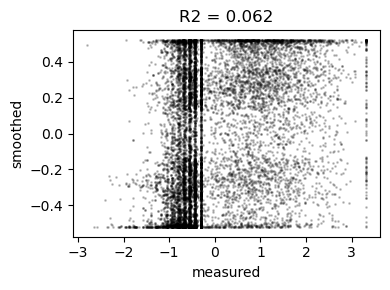

/home/jbreda/mambaforge/envs/work_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


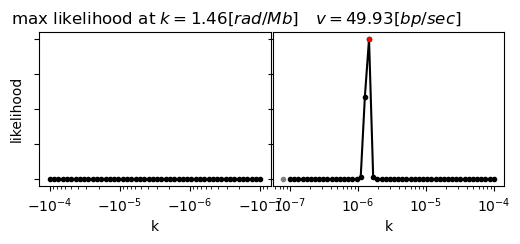

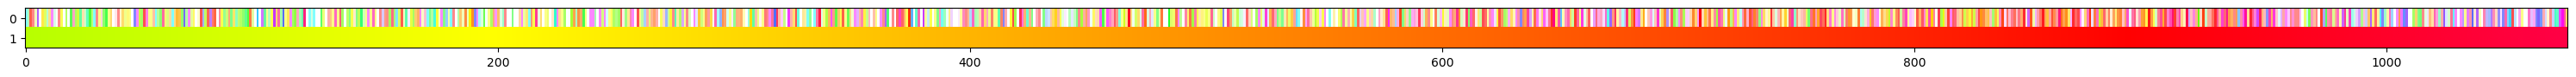

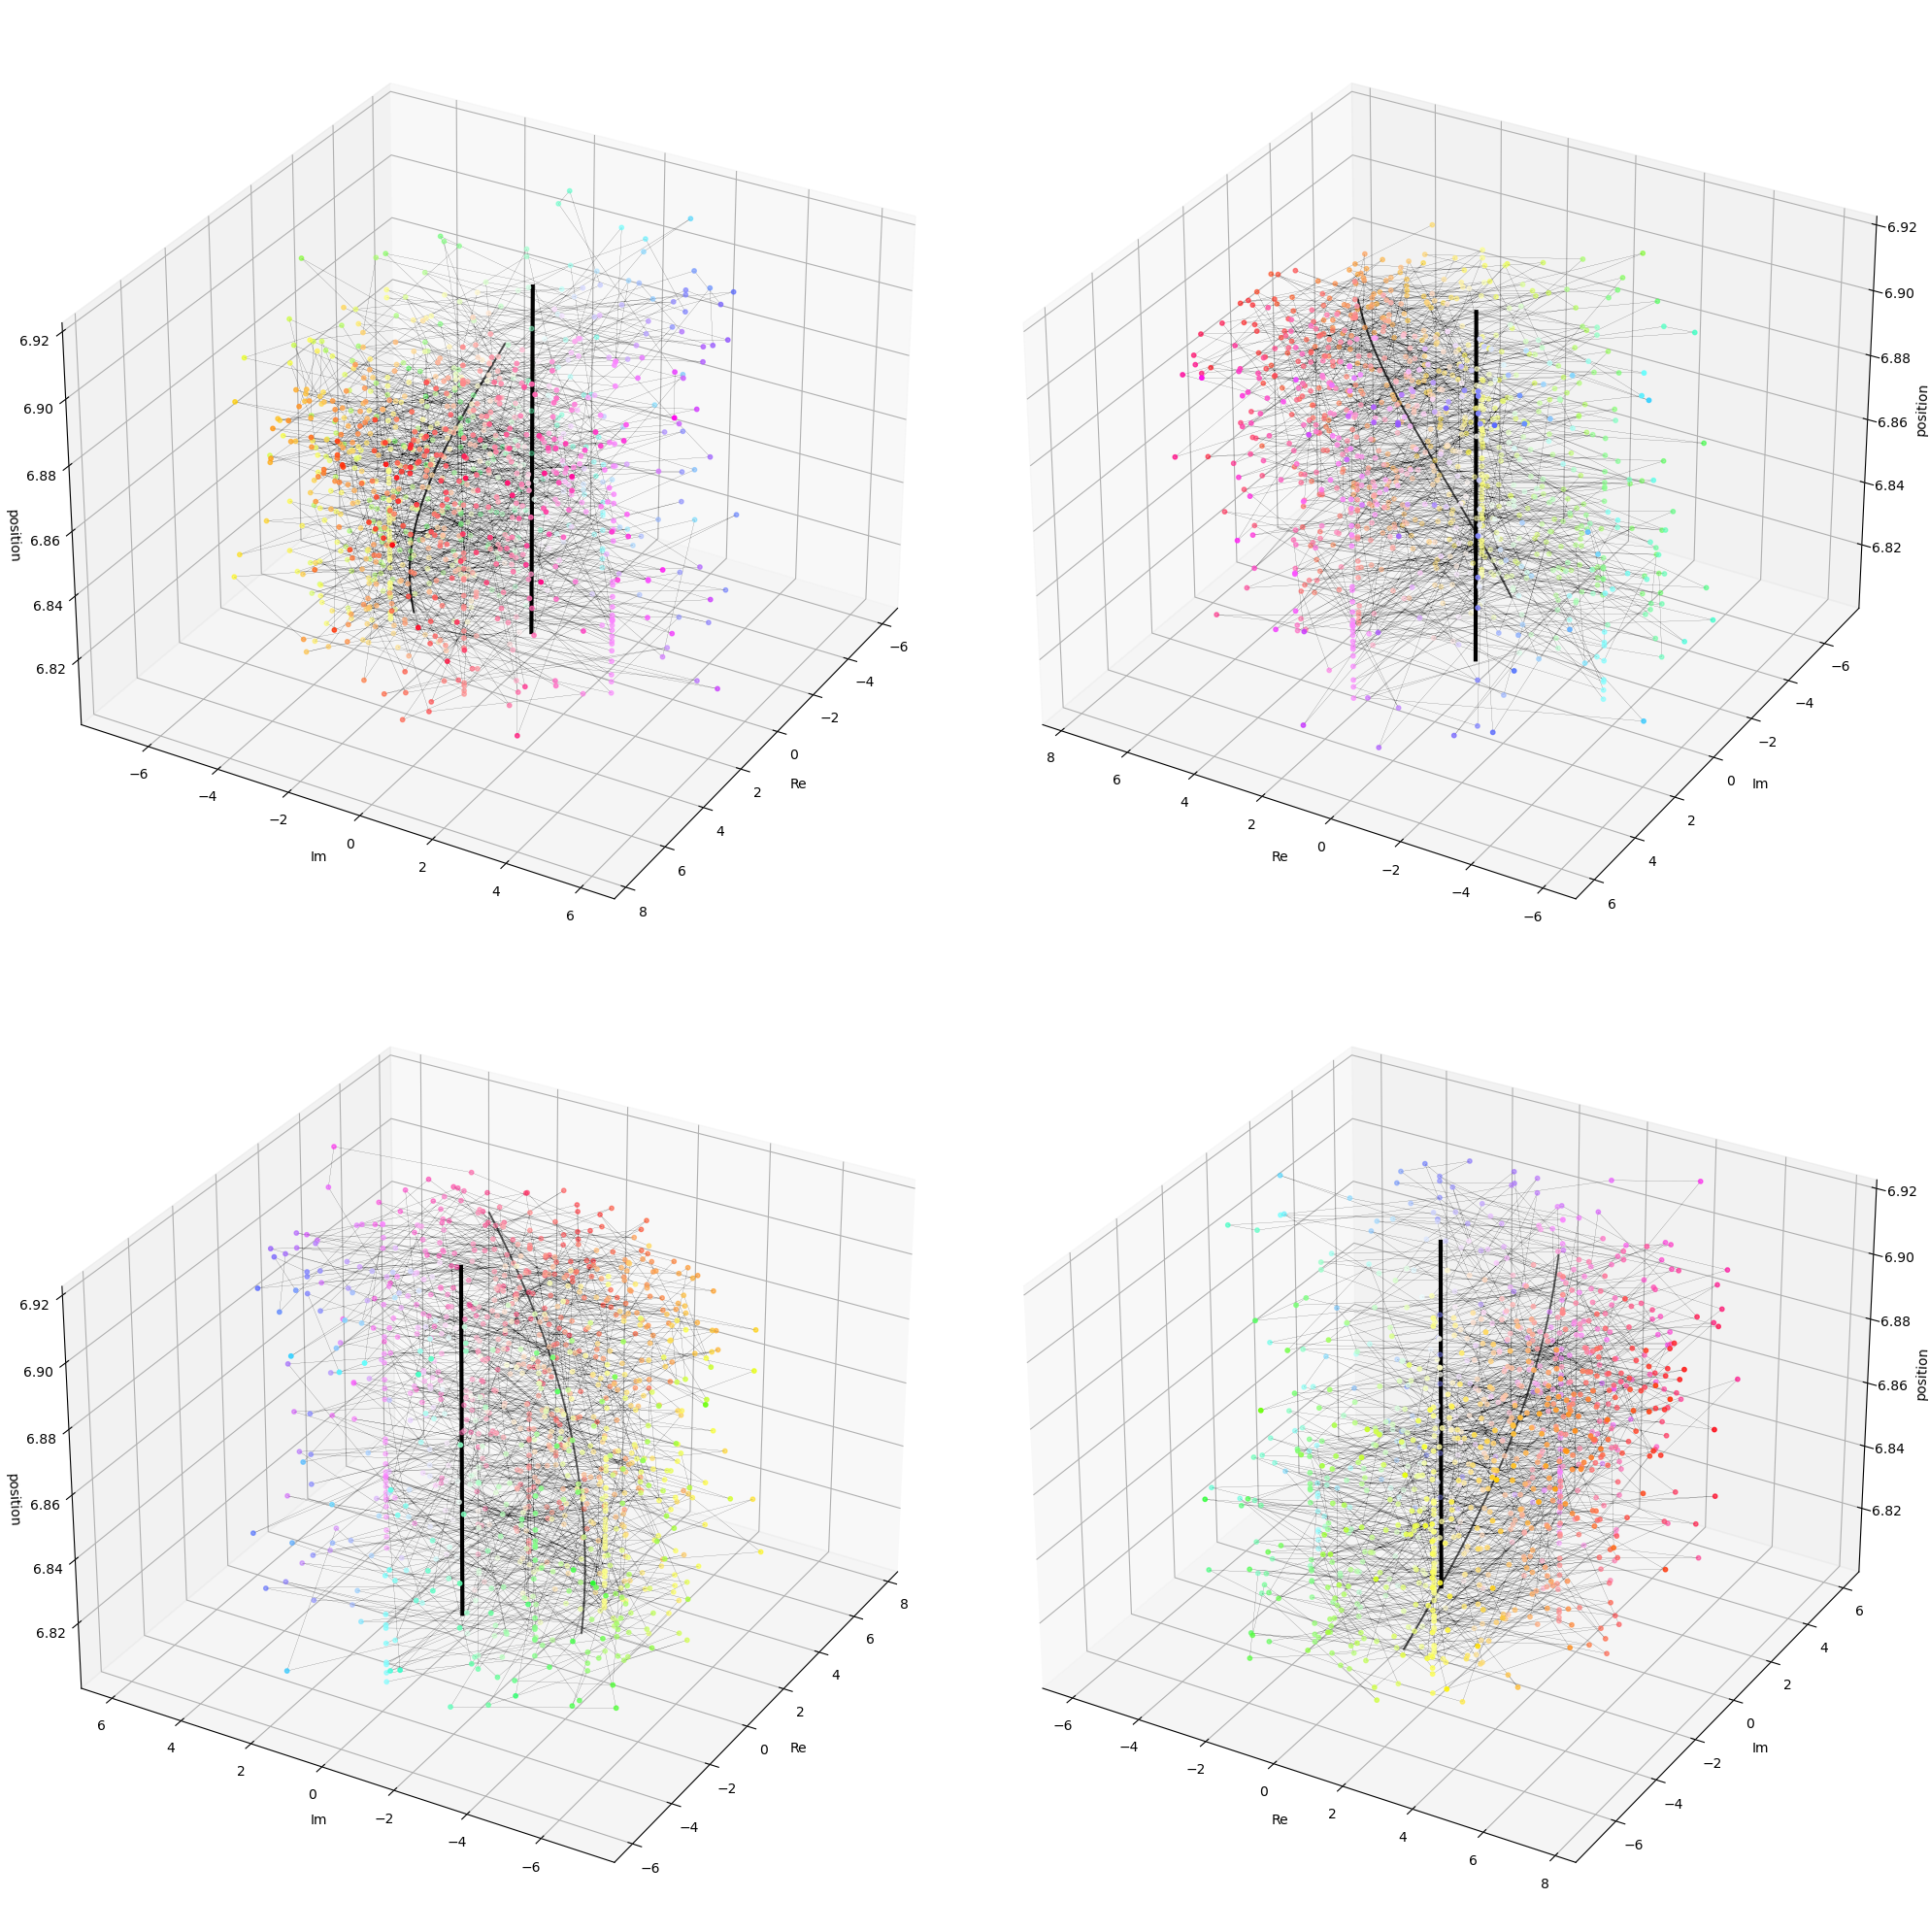

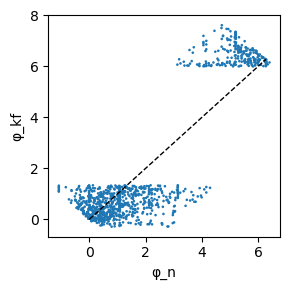

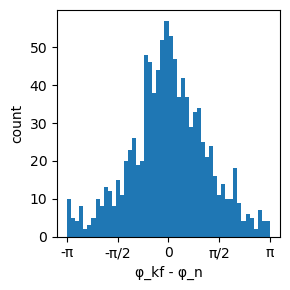

In [22]:

# get overall phase and amplitude
df_overall = pd.read_csv(f'../results/phase_amp/overall_phase_amp_1000bp.csv',index_col=0,sep='\t')
r_genome = df_overall.amplitude.values
φ_genome = df_overall.phase.values
a_genome = r_genome * np.cos(φ_genome)
b_genome = r_genome * np.sin(φ_genome)
μ_genome = a_genome + 1j*b_genome

del df_overall, r_genome, φ_genome, a_genome, b_genome

# get noise model parametrs
bin_size = 1000 # bin size
fin = open(f'../results/binned_norm_counts/Noise_model_parameters_{bin_size}bp.csv','r')
lines = fin.readlines()
Noise_params = {}
for line in lines:
    if line[0] == '#':
        continue
    line = line.strip().split('\t')
    Noise_params[line[0]] = float(line[1])
fin.close()

MY_WINS = [['chr17',34_850_000, 35_150_000,'-'],['chr17',26_750_000, 27_050_000,'+'],['chr1',67_887_782,69_322_280,'-']]
MY_WINS = [['chr1',68071346,69147218,'-','Erbb4']]
bw_folder = '../results/binned_norm_counts'

T = np.arange(0,48,4) # time points
P = 24 # period
ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state
dx = bin_size # distance between positions

K_max = -4
K_min = -7
K = np.logspace(K_max,K_min,50)
K = np.append(np.append(K,0),-np.flip(K))

for Rotate in [False]:
    for My_win in MY_WINS:
        [chr,start,end,strand,name] = My_win

        coord = f'{chr}:{start}:{end}:{strand}'

        df = get_data(coord,bw_folder,bin_size)
        
        # get small region of the chromosome
        positions = df.index # positions
        measurements = df.values.T # time x position

        # fill missing values
        x = np.arange(positions[0],positions[-1]+1,bin_size)
        idx = [np.where(x==pos)[0][0] for pos in positions]
        X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
        X[:,idx] = measurements
        [m,N_mes] = X.shape # number of measurements

        # Use unnormalized expression at each position for R
        R = np.zeros((len(x),m,m))
        # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
        for i in range(len(x)):
            if np.isnan(X[:,i]).all():
                continue
            R[i,:,:] = np.diag(Noise_params['a'] * np.exp(-Noise_params['b'] * X[:,i] ) + Noise_params['c'] )

        # normalize
        X[:,idx] -= measurements.mean(0)
        sigma = X[:,idx].std(axis=0)
        sigma[sigma==0] = 1
        X[:,idx] /= sigma

        # Amp and phase of fourier transform
        f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
        f_n -= μ_genome
        a_n = 4/m * np.abs(f_n)
        # normalize
        φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
        φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

        # observation model: inverse fourier transform
        H = np.zeros((m,n))
        H[:,0] = np.cos(ω*T)
        H[:,1] = -np.sin(ω*T)
        H /= 6

        with Pool(processes=24) as pool:
            OUT = pool.map(partial(run_kalman_with_k,X,H,R,dx,Rotate),K)

        LL = np.array([OUT[i][0] for i in range(len(K))])
        idx_best = np.argmax(LL)
        μ_tT_best = OUT[idx_best][1]
        Σ_tT_best = OUT[idx_best][2]

        smoothed = H @ μ_tT_best
        R2 = 1 - np.nansum( (X - smoothed)**2 )/np.nansum( (X - np.nanmean(X))**2 )

        # plot smoothed vs measured
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(X.flatten(),smoothed.flatten(),s=1,c='k',alpha=.2)
        ax.set_xlabel('measured')
        ax.set_ylabel('smoothed')
        ax.set_title(f'R2 = {R2:.3f}')

        fig.tight_layout()


        plot_log_likelihood(LL,K,fname=f'fig/kalman_loglikelihood_{name}_kf.pdf')

        # Compare best with bin by bin fourrier transform

        # Amp and phase of kalman filter
        μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
        μ_tT_best_C -= μ_genome
        a_kf = 4/m * np.abs(μ_tT_best_C)
        φ_kf = -np.arctan2(np.imag(μ_tT_best_C),np.real(μ_tT_best_C))
        φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

        plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,fname=[f'fig/kalman_smooth_{name}_kf.pdf',f'fig/kalman_smooth_{name}_kf_3D.pdf'],tube=False)
        plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf,fname=[f'fig/kalman_scatter_phi_{name}.pdf',f'fig/kalman_hist_phi_diff_{name}.pdf'])
            


### Per gene

Erbb4


/tmp/ipykernel_18153/3563745229.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
/tmp/ipykernel_18153/3563745229.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(fname)
/home/jbreda/mambaforge/envs/work_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


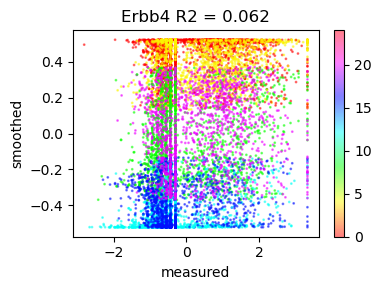

/home/jbreda/mambaforge/envs/work_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


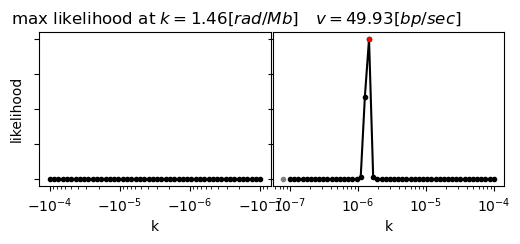

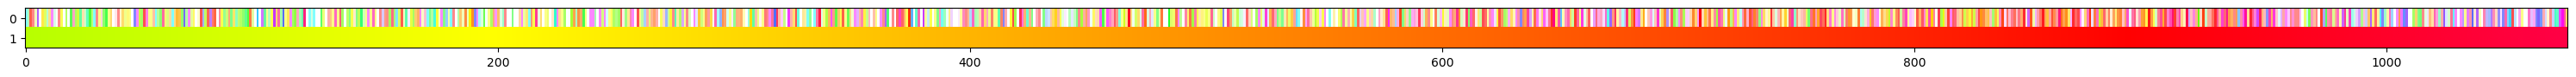

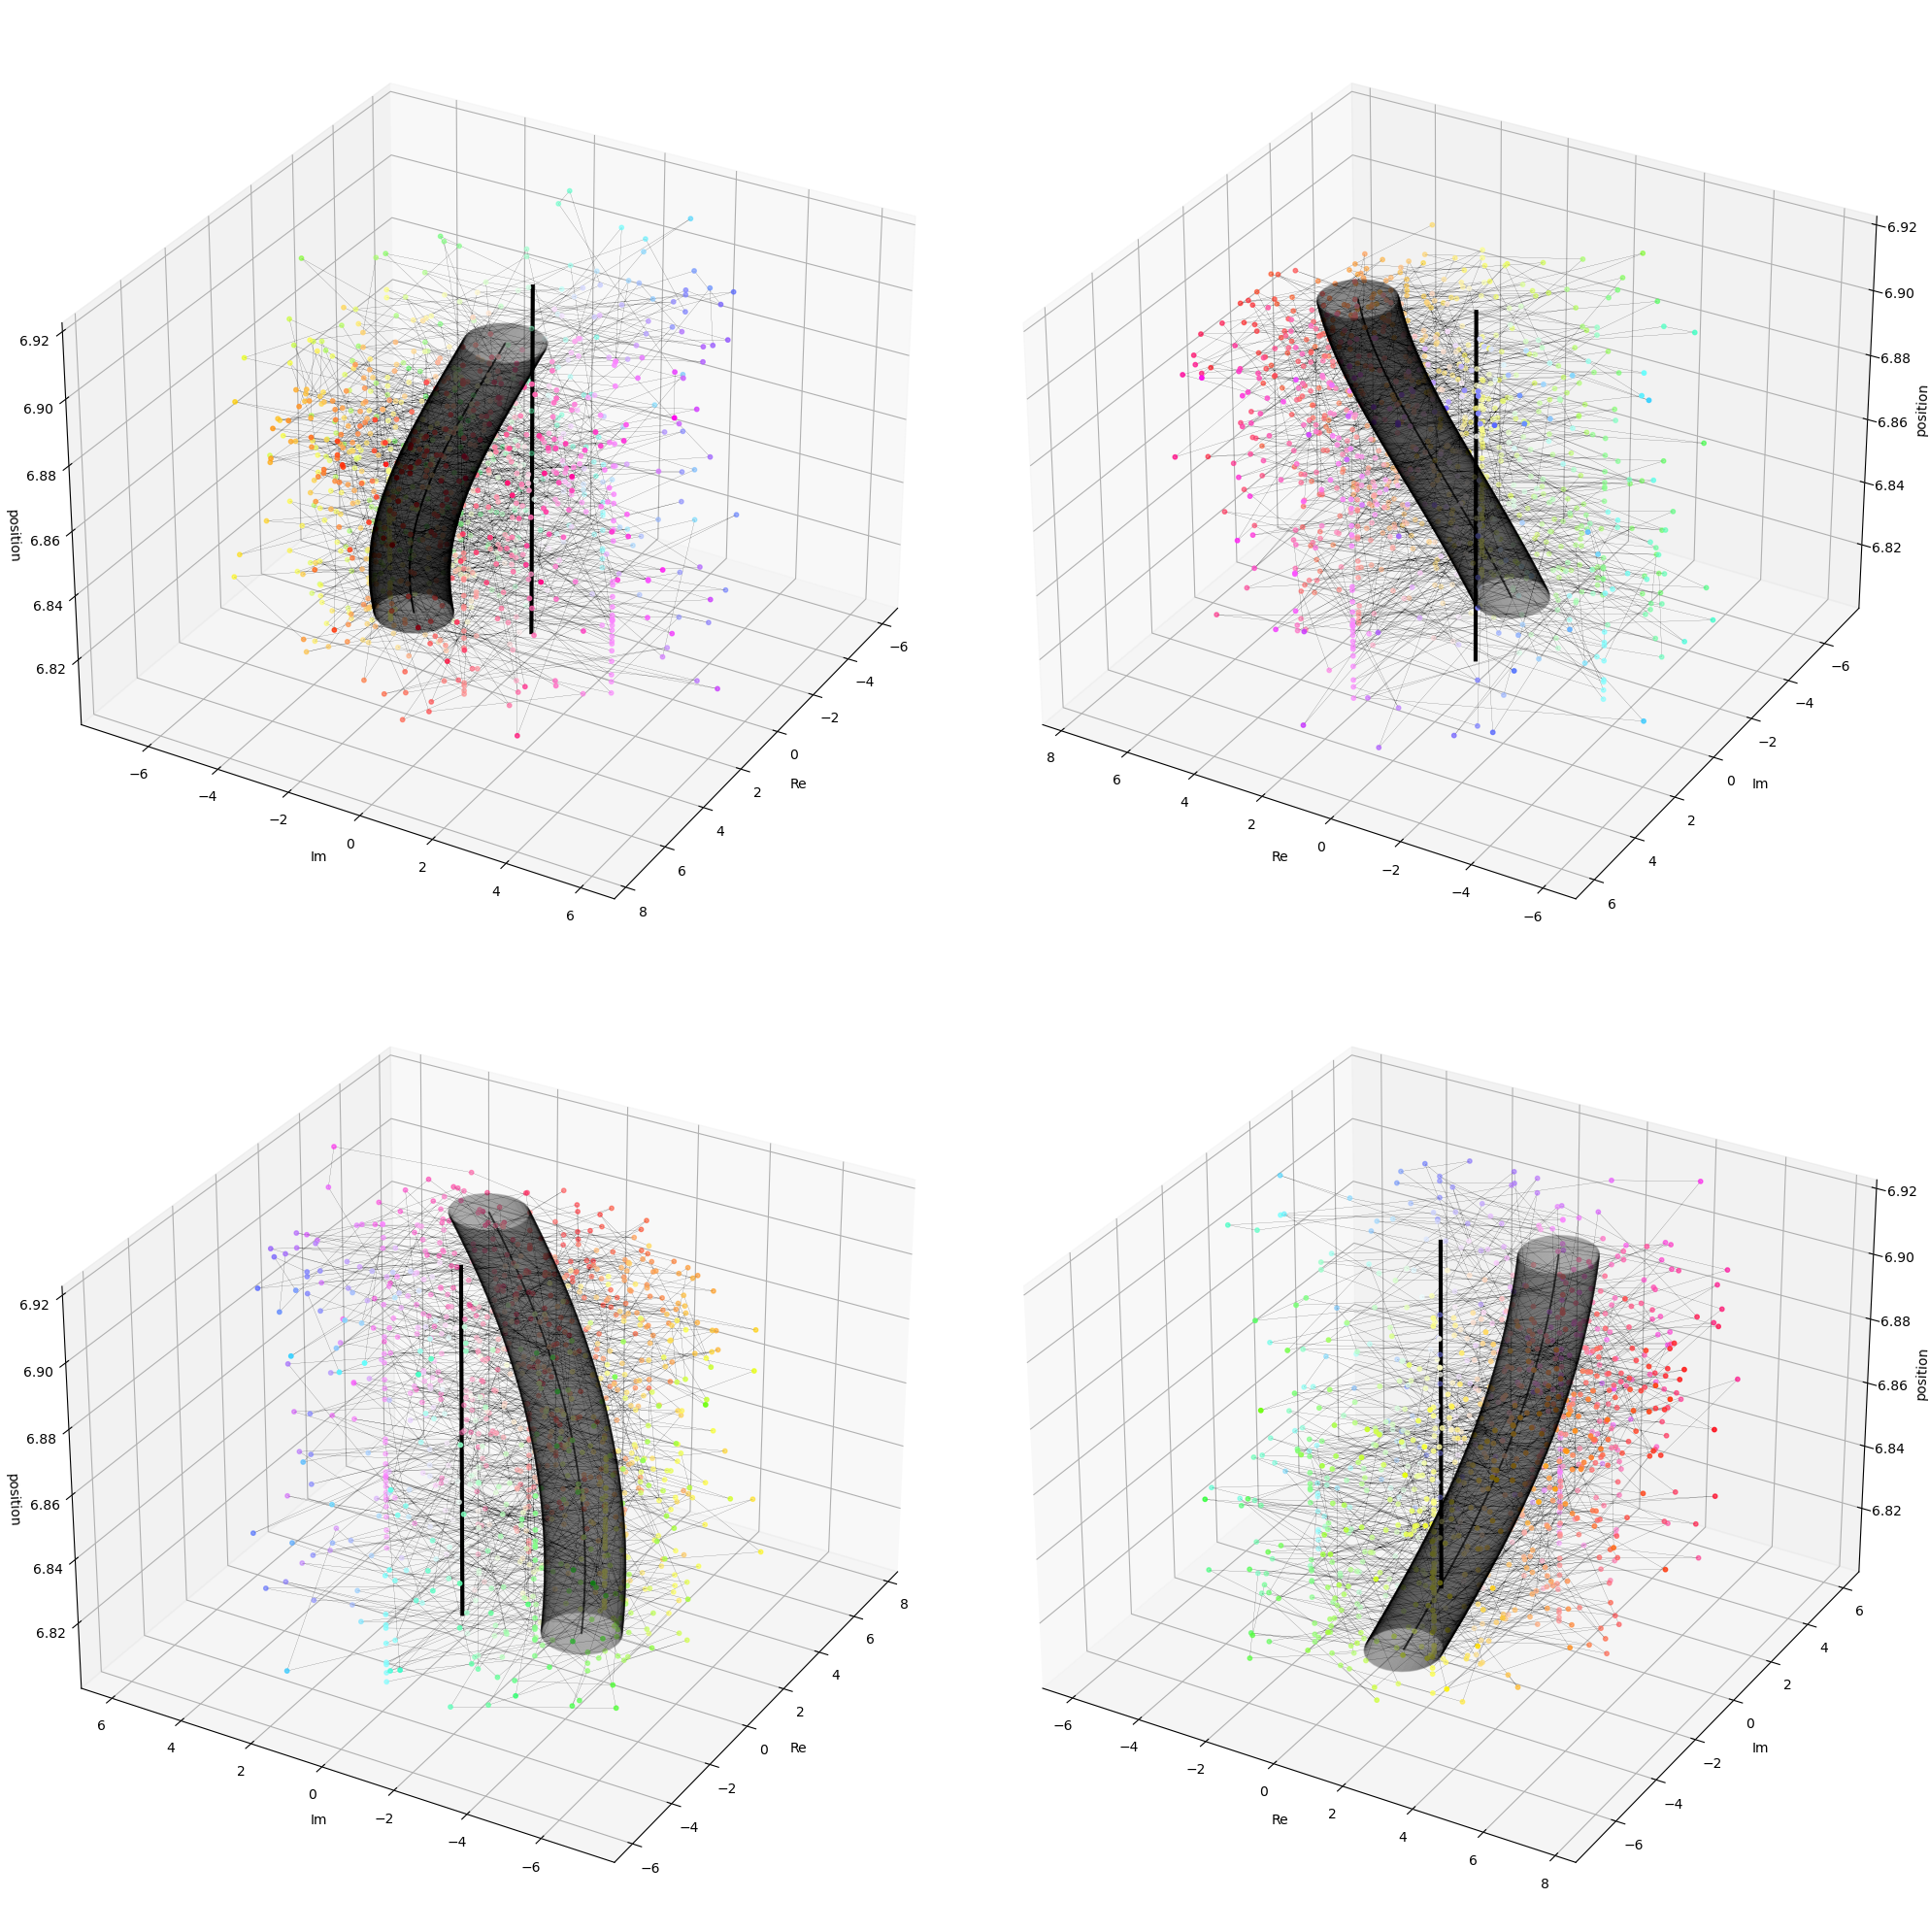

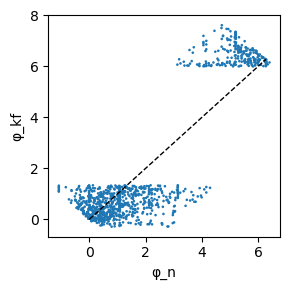

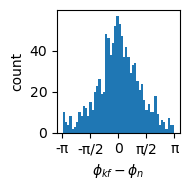

In [29]:
bin_size = 1000

# get overall phase and amplitude
df_overall = pd.read_csv(f'../results/phase_amp/overall_phase_amp_{bin_size}bp.csv',index_col=0,sep='\t')
r_genome = df_overall.amplitude.values
φ_genome = df_overall.phase.values
a_genome = r_genome * np.cos(φ_genome)
b_genome = r_genome * np.sin(φ_genome)
μ_genome = a_genome + 1j*b_genome

del df_overall, r_genome, φ_genome, a_genome, b_genome

# get noise model parametrs
fin = open(f'../results/binned_norm_counts/Noise_model_parameters_{bin_size}bp.csv','r')
lines = fin.readlines()
Noise_params = {}
for line in lines:
    if line[0] == '#':
        continue
    line = line.strip().split('\t')
    Noise_params[line[0]] = float(line[1])
fin.close()

bw_folder = '../results/binned_norm_counts'

# Read gtf file
infile = '../resources/genome/GRCm39/gene_protein_coding.gtf'
gtf = pd.read_csv(infile,sep='\t',header=None)
gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')

Genes = ["Cry1","Cry2","Nr1d1","Nr1d2","Per1","Per2","Per3","Ciart","Clock","Arntl","Npas2","Dbp","Tef","Hlf","Nfil3","Bhlhe40","Fbxl3","Csnk1e","Rora","Rorb","Rorc","Gnai2","Xkr4"]
Genes = ["Erbb4"]
T = np.arange(0,48,4) # time points
P = 24 # period
ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state
dx = bin_size # distance between positions

K_max = -4
K_min = -7
K = np.logspace(K_max,K_min,50)
K = np.append(np.append(K,0),-np.flip(K))

strand_K_max_R2 = np.zeros((len(K),3))

for g, gene in enumerate(Genes):
    print(gene)

    coord = gtf.loc[gtf.gene_name==gene,['chr','start','end','strand']]
    chr = coord.chr.values[0]
    start = coord.start.values[0]
    end = coord.end.values[0]
    strand = coord.strand.values[0]

    if strand == '+':
        strand_K_max_R2[g,0] = 1
    elif strand == '-':
        strand_K_max_R2[g,0] = -1

    coord = f'{chr}:{start}:{end}:{strand}'

    df = get_data(coord,bw_folder,bin_size)
    
    # get small region of the chromosome
    positions = df.index # positions
    measurements = df.values.T # time x position

    for Rotate in [False]:
        
        # fill missing values
        x = np.arange(positions[0],positions[-1]+1,bin_size)
        idx = [np.where(x==pos)[0][0] for pos in positions]
        X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
        X[:,idx] = measurements
        [m,N_mes] = X.shape # number of measurements

        # Use unnormalized expression at each position for R
        R = np.zeros((len(x),m,m))
        # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
        for i in range(len(x)):
            if np.isnan(X[:,i]).all():
                continue
            R[i,:,:] = np.diag(Noise_params['a'] * np.exp(-Noise_params['b'] * X[:,i] ) + Noise_params['c'] )

        # normalize
        X[:,idx] -= measurements.mean(0)
        sigma = X[:,idx].std(axis=0)
        sigma[sigma==0] = 1
        X[:,idx] /= sigma

        # Amp and phase of fourier transform
        f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
        f_n -= μ_genome
        a_n = 4/m * np.abs(f_n)
        # normalize
        φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
        φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

        # observation model: inverse fourier transform
        H = np.zeros((m,2))
        H[:,0] = np.cos(ω*T)
        H[:,1] = -np.sin(ω*T)
        H /= 6
        # measurement noise: R = R_a * exp(-R_b * x) + R_c


        with Pool(processes=24) as pool:
            OUT = pool.map(partial(run_kalman_with_k,X,H,R,dx,Rotate),K)

        LL = np.array([OUT[i][0] for i in range(len(K))])
        idx_best = np.argmax(LL)
        μ_tT_best = OUT[idx_best][1]
        Σ_tT_best = OUT[idx_best][2]

        strand_K_max_R2[g,1] = K[idx_best]

        smoothed = H @ μ_tT_best
        R2 = 1 - np.nansum( (X - smoothed)**2 )/np.nansum( (X - np.nanmean(X))**2 )

        strand_K_max_R2[g,2] = R2

        if True:
            # plot smoothed vs measured
            color = np.repeat(T[:,None]%24,X.shape[1],axis=1)

            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)
            h = ax.scatter(X.flatten(),smoothed.flatten(),s=1,c=color.flatten(), alpha=.5,cmap='hsv',vmin=0,vmax=24)
            # colorbar
            cbar = plt.colorbar(h)
            ax.set_xlabel('measured')
            ax.set_ylabel('smoothed')
            ax.set_title(f'{gene} R2 = {R2:.3f}')
            fig.tight_layout()

            plot_log_likelihood(LL,K,fname=f'fig/kalman_loglikelihood_{name}_kf.pdf')

            # Compare best with bin by bin fourrier transform

            # Amp and phase of kalman filter
            μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
            μ_tT_best_C -= μ_genome
            a_kf = 4/m * np.abs(μ_tT_best_C)
            φ_kf = -np.arctan2(np.imag(μ_tT_best_C),np.real(μ_tT_best_C))
            φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

            plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,fname=[f'fig/kalman_smooth_{name}_kf.pdf',f'fig/kalman_smooth_{name}_kf_3D.pdf'],tube=True)
            plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf,fname=[f'fig/kalman_scatter_phi_{name}.pdf',f'fig/kalman_hist_phi_diff_{name}.pdf'])
                


/home/jbreda/mambaforge/envs/work_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  func(*args, **kwargs)


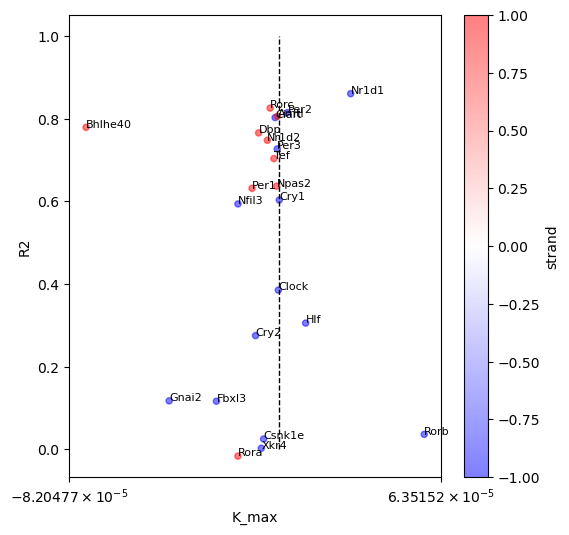

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
h = ax.scatter(strand_K_max_R2[:,1],strand_K_max_R2[:,2],s=20,c=strand_K_max_R2[:,0], alpha=.5,cmap='bwr',vmin=-1,vmax=1)
ax.plot([0,0],[0,1],'k--',lw=1)
for g in range(len(Genes)):
    ax.text(strand_K_max_R2[g,1],strand_K_max_R2[g,2],Genes[g],fontsize=8)
ax.set_xscale('symlog')
ax.set_xlabel('K_max')
ax.set_ylabel('R2')
# add colorbar
cbar = plt.colorbar(h)
cbar.set_label('strand')


### With mean

In [32]:
#My_win = [35_000_000, 35_150_000]
My_win = [34_891_000, 35_434_000]
#My_win = [34_000_000, 36_000_000]
#My_win = [26_500_000, 27_500_000]
#My_win = [26_650_000, 27_150_000]
#My_win = [24_000_000, 30_000_000]


#['chr1',68071346,69147218,'-','Erbb4']

# Kalman filter
#Λ = np.logspace(4.5, 6, 40) # wavelengths in bp
# add the negative values
#Λ = np.append(np.append(Λ,np.inf),-np.flip(Λ))
#K = 2*np.pi/Λ # wave numbers

K_max = -4
K_min = -7
K = np.logspace(K_max,K_min,20)
K = np.append(np.append(K,0),-np.flip(K))

T = np.arange(0,48,4)
P = 24
ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 3 # number complex state
dx = bin_size # distance between positions

Strands = ['+','-']
strand_dict = {'+': 'forward', '-': 'reverse'}
for strand in Strands:
    print(strand)

    # get small region of the chromosome
    idx_pos = (df.index >= My_win[0]) & (df.index <= My_win[1])
    measurements = df.loc[idx_pos,[f"{t}{strand}" for t in T]].values.T # time x position
    
    # fill missing values
    positions = df.loc[idx_pos,:].index # positions
    x = np.arange(positions[0],positions[-1]+1,bin_size)
    idx = [np.where(x==pos)[0][0] for pos in positions]
    X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
    X[:,idx] = measurements
    [m,N_mes] = X.shape # number of measurements

    # save unnormalized expression at each position for kf.setR()
    X_unnorm = X.copy()

    # normalize
    X[:,idx] -= measurements.mean(0)
    sigma = X[:,idx].std(axis=0)
    sigma[sigma==0] = 1
    X[:,idx] /= sigma
    X[:,idx] += measurements.mean(0) # add back the mean

    # fourrier transform of measurments bin per bin
    f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
    f_n -= μ_genome # remove overall oscillation
    a_n = 4/m * np.abs(f_n)
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    # Initialize variables
    LL = np.zeros(len(K))
    μ_tT_best = np.zeros((n,N_mes))
    Σ_tT_best = np.zeros((n,n,N_mes))
    ll_best = -np.inf
    for l,k in enumerate(K):
        print(f'{l+1}/{len(K)}',end='\r')

        # forward model: rotation matrix
        θ = dx*k
        F = np.zeros((n,n))
        F[0,0] = 1
        F[1,1] = np.cos(θ)
        F[1,2] = -np.sin(θ)
        F[2,1] = np.sin(θ)
        F[2,2] = np.cos(θ)

        # process noise
        Q = np.eye(n)*((θ/10)**2)
        # observation model: inverse fourier transform
        H = np.zeros((m,n))
        H[:,0] = 1
        H[:,1] = np.cos(ω*T)
        H[:,2] = -np.sin(ω*T)
        H /= 6
        # measurement noise: R = R_a * exp(-R_b * x) + R_c

        # initial state
        μ_0 = np.zeros(n)
        Σ_0 = np.eye(n)*1

        kf = KalmanFilter(F=F, H=H, Q=Q, R_a=R_a, R_b=R_b, R_c=R_c, μ_0=μ_0, Σ_0=Σ_0)

        μ_pred = np.zeros((n,N_mes))
        Σ_pred = np.zeros((n,n,N_mes))
        predicted = np.zeros((m,N_mes))
        μ_t = np.zeros((n,N_mes))
        Σ_t = np.zeros((n,n,N_mes))
        filtered = np.zeros((m,N_mes))
        for i,z in enumerate(X.T):
            μ_pred[:,i], Σ_pred[:,:,i] = kf.predict(i)
            μ_t[:,i], Σ_t[:,:,i] = kf.update(z,X_unnorm[:,i])

        #test Forward-Backward
        forward_table, LL[l] = kf.fullForward(X,X_unnorm)

        μ_tT, Σ_tT = kf.Backward(forward_table,F)
        μ_tT = np.array(μ_tT).T

        # save the best
        if LL[l] > ll_best:
            ll_best = LL[l]
            μ_tT_best = μ_tT
            Σ_tT_best = Σ_tT
    
    
    plot_log_likelihood(LL,K)
    
    # Compare best with bin by bin fourrier transform

    # Amp and phase of kalman filter
    μ_tT_best_C = μ_tT_best[1,:] + 1j*μ_tT_best[2,:]
    μ_tT_best_C -= μ_genome
    a_kf = 4/m * np.abs(μ_tT_best_C)
    φ_kf = -np.arctan2(np.imag(μ_tT_best_C),np.real(μ_tT_best_C))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,tube=True)
    plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf)
    


+


KeyError: "None of [Index(['0+', '4+', '8+', '12+', '16+', '20+', '24+', '28+', '32+', '36+',\n       '40+', '44+'],\n      dtype='object')] are in the [columns]"

'reverse'

### fixed k rotating Q

In [33]:



plot_log_likelihood(LL,K)

# Compare best with bin by bin fourrier transform
# Amp and phase of fourier transform
f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
f_n -= μ_genome
a_n = 4/m * np.abs(f_n)
# normalize
φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

# Amp and phase of kalman filter
μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
μ_tT_best_C -= μ_genome
a_kf = 4/m * np.abs(μ_tT_best_C)
φ_kf = -np.arctan2(np.imag(μ_tT_best_C),np.real(μ_tT_best_C))
φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,tube=True)
plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf)



TypeError: plot_log_likelihood() missing 1 required positional argument: 'fname'

### k as hidden variable

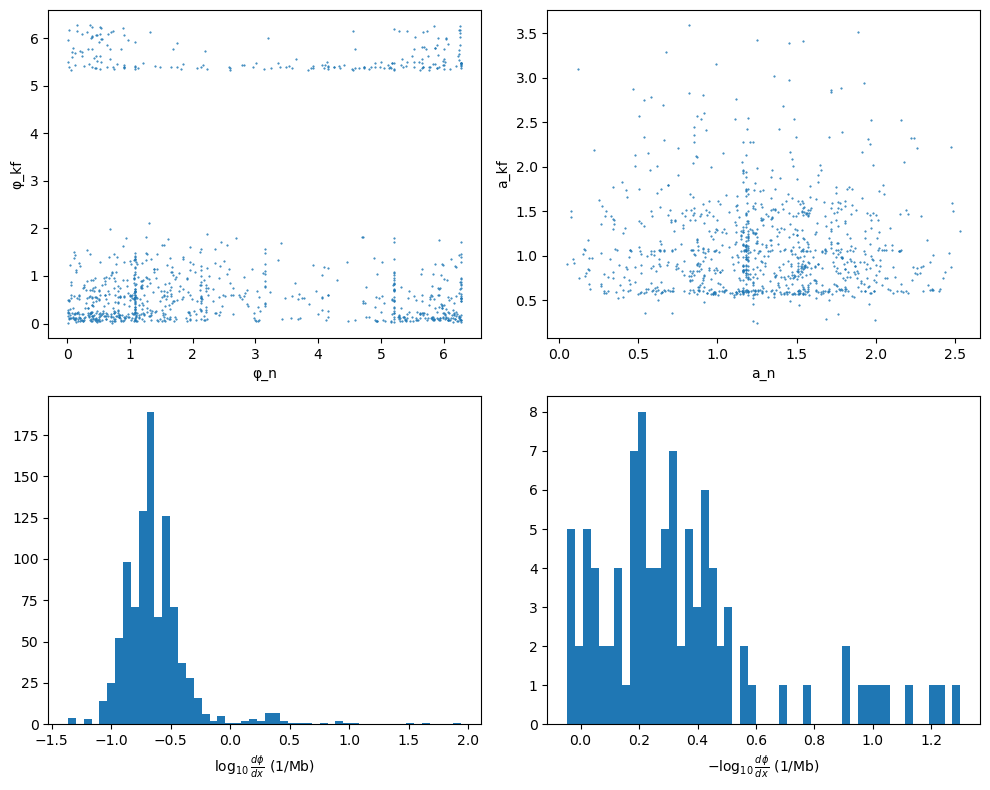

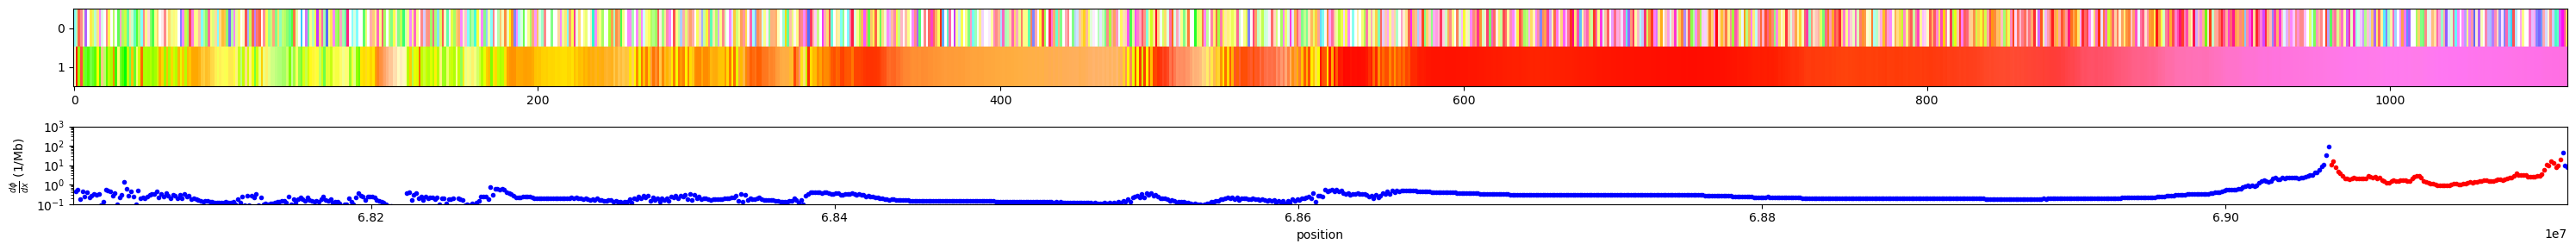

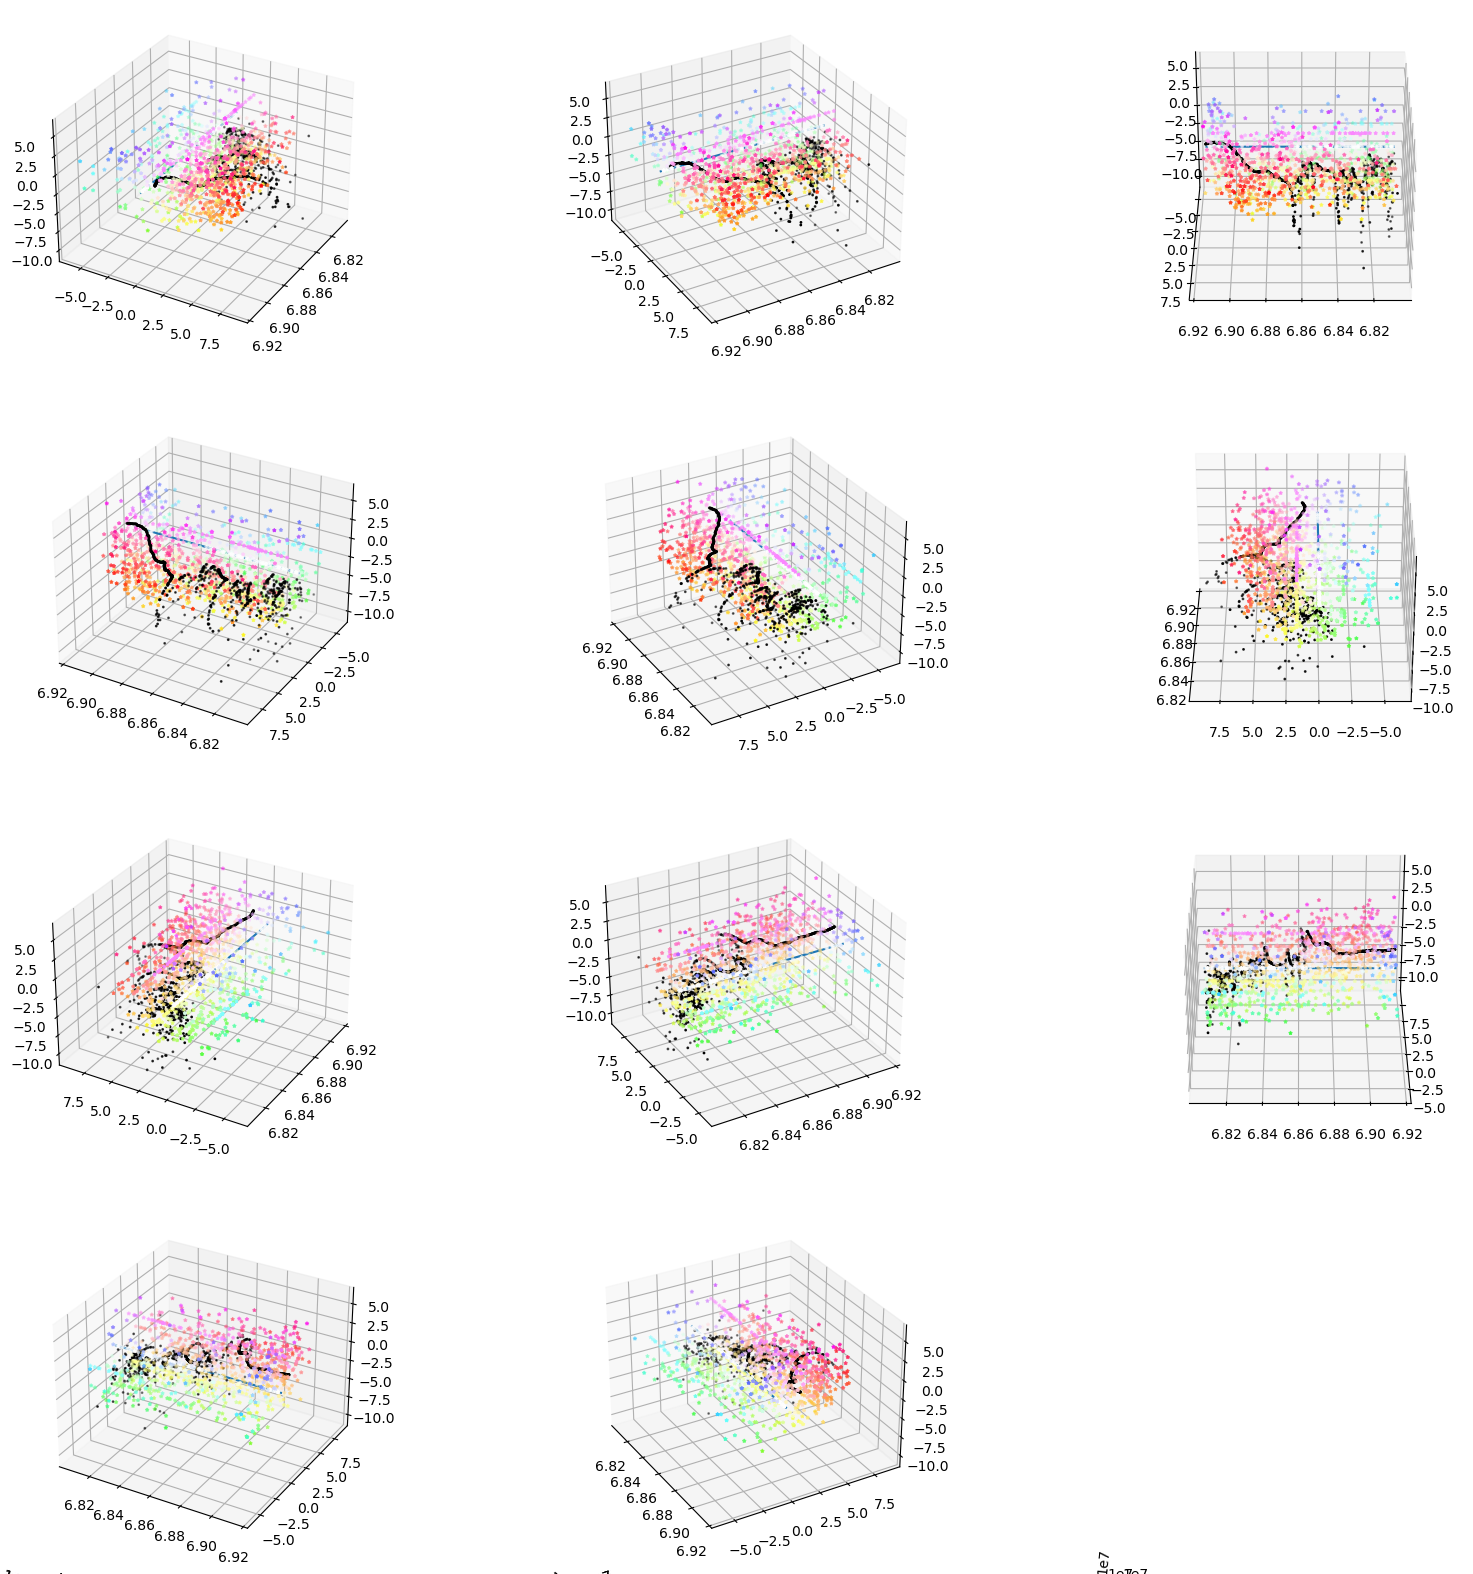

In [46]:
#My_win = [35_000_000, 35_150_000]
#My_win = [34_891_000, 35_434_000]
#My_win = [34_000_000, 36_000_000]
#My_win = [26_500_000, 27_500_000]
My_win = [26_750_000, 27_050_000]
#My_win = [24_000_000, 30_000_000]

MY_WIN = [['chr1',68071346,69147218,'-','Erbb4']]


for My_win in MY_WIN:
    [chr,start,end,strand,name] = My_win
    coord = f'{chr}:{start}:{end}:{strand}'
    df = get_data(coord,bw_folder,bin_size)

    # get small region of the chromosome
    # get small region of the chromosome
    positions = df.index # positions
    measurements = df.values.T # time x position

    # fill missing values
    x = np.arange(positions[0],positions[-1]+1,bin_size)
    idx = [np.where(x==pos)[0][0] for pos in positions]
    X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
    X[:,idx] = measurements
    [m,N_mes] = X.shape # number of measurements

    # Use unnormalized expression at each position for R
    R = np.zeros((len(x),m,m))
    # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
    for i in range(len(x)):
        if np.isnan(X[:,i]).all():
            continue
        R[i,:,:] = np.diag(Noise_params['a'] * np.exp(-Noise_params['b'] * X[:,i] ) + Noise_params['c'] )
    
    # normalize
    X[:,idx] -= measurements.mean(0)
    sigma = X[:,idx].std(axis=0)
    sigma[sigma==0] = 1
    X[:,idx] /= sigma

    # Amp and phase of fourier transform
    f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
    f_n -= μ_genome
    a_n = 4/m * np.abs(f_n)
    # normalize
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    ω = 2*np.pi/P # angular frequency
    m = len(T) # number of time points
    n = 4 # number hidden state
    dx = bin_size # distance between positions

    # forward model: rotation matrix
    k0 = 1e-6
    θ = dx*k0
    F = np.zeros((n,n))
    F[0,0] = np.cos(θ)
    F[0,1] = -np.sin(θ)
    F[1,0] = np.sin(θ)
    F[1,1] = np.cos(θ)
    F[2,2] = 1
    F[3,3] = 1

    # process noise
    sigma = dx*1e-5
    Q = np.diag([sigma/10,sigma/10,1e-12,1e-12])
    #Q[0,0] = .001 # σ_r ^2
    #Q[1,1] = (θ/10)**2 # σ_φ ^2

    # observation model: inverse fourier transform
    H = np.zeros((m,n))
    H[:,0] = np.cos(ω*T)
    H[:,1] = -np.sin(ω*T)
    H /= 6

    # initial state
    μ_0 = np.ones(n)*.001
    Σ_0 = np.eye(n)*.1

    kf = KalmanFilter_k_hidden(F=F, H=H, Q=Q, R=R, μ_0=μ_0, Σ_0=Σ_0, dx=dx)

    μ_pred = np.zeros((n,N_mes))
    Σ_pred = np.zeros((n,n,N_mes))
    predicted = np.zeros((m,N_mes))
    μ_t = np.zeros((n,N_mes))
    Σ_t = np.zeros((n,n,N_mes))
    filtered = np.zeros((m,N_mes))
    for t,z in enumerate(X.T):
        μ_pred[:,t], Σ_pred[:,:,t] = kf.predict(t)
        μ_t[:,t], Σ_t[:,:,t] = kf.update(z,t)

    #Forward-Backward
    forward_table, ll = kf.fullForward(X)
    μ_tT, Σ_tT = kf.Backward(forward_table,F)
    μ_tT = np.array(μ_tT).T

    # Compare best with bin by bin fourrier transform

    # plot phase per bin
    h = φ_n/(2*np.pi)
    s = a_n/np.nanmax(a_n)
    v = np.ones(len(x))
    color_f = hsv_to_rgb_v(h,s,v)
    f_n[np.isnan(f_n)] = 0

    μ_tT_C = μ_tT[0,:] + 1j*μ_tT[1,:]
    μ_tT_C -= μ_genome
    a_kf = 4/m * np.abs(μ_tT_C)
    φ_kf = -np.arctan2(np.imag(μ_tT_C),np.real(μ_tT_C))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    dφ_dt = ( μ_tT[3,:]*μ_tT[0,:] - μ_tT[2,:]*μ_tT[1,:] )/( μ_tT[0,:]**2 + μ_tT[1,:]**2 )
    # change unit rad/bp -> bp/s
    dφ_dt /= 2*np.pi
    dφ_dt *= 24*3600
    dφ_dt = 1/dφ_dt
    

    fig,axes = plt.subplots(2,2,figsize=(10,8))
    ax = axes[0,0]
    ax.scatter(φ_n,φ_kf,s=1,marker='.')
    ax.set_xlabel('φ_n')
    ax.set_ylabel('φ_kf')

    ax = axes[0,1]
    ax.scatter(a_n,a_kf,s=1,marker='.')
    ax.set_xlabel('a_n')
    ax.set_ylabel('a_kf')

    ax = axes[1,0]
    ax.hist(np.log10(dφ_dt[dφ_dt>0]),bins=50)
    ax.set_xlabel(r'$\log_{10} \frac{d\phi}{dx}$ (1/Mb)')

    ax = axes[1,1]
    ax.hist(np.log10(-dφ_dt[dφ_dt<0]),bins=50)
    ax.set_xlabel(r'$-\log_{10} \frac{d\phi}{dx}$ (1/Mb)')

    fig.tight_layout()

    # plot phase per bin
    h = φ_kf/(2*np.pi)
    s = a_kf/a_kf.mean()
    s[s>1] = 1
    v = np.ones(len(x))
    color_kf = hsv_to_rgb_v(h,s,v)
    Φ = np.ones((2,len(x),3))
    Φ[0,:] = color_f
    Φ[1,:] = color_kf

    fig, axes = plt.subplots(2,1,figsize=(30,3))

    ax = axes[0]
    ax.imshow(Φ,aspect='auto',interpolation='none')

    ax = axes[1]

    idx_pos = dφ_dt > 0
    ax.plot(x[idx_pos],dφ_dt[idx_pos],'b.')
    idx_neg = dφ_dt < 0
    ax.plot(x[idx_neg],-dφ_dt[idx_neg],'r.')
    ax.set_ylim(1e-1,1e3)
    ax.set_yscale('log')
    ax.set_xlim(x[0],x[-1])
    ax.set_xlabel('position')
    ax.set_ylabel(r'$\frac{d\phi}{dx}$ (1/Mb)')

    fig.tight_layout()
    fig.savefig(f'fig/kalman_k_hiddend_phase_per_bin_{name}.pdf')

    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(30,360,30) ):
        ax = fig.add_subplot(4,3,f+1, projection='3d')
        ax.scatter(xs=x, ys=f_n.real, zs=f_n.imag,color=Φ[0,:],s=5,marker='*')
        ax.scatter(xs=x, ys=μ_tT_C.real, zs=μ_tT_C.imag,color='k',s=1,marker='o')
        #ax.plot3D(positions,f_n.real,f_n.imag,color='k',linewidth=0.5)
        #for i in range(len(positions)):
        #    ax.plot3D([positions[i],positions[i]],[f_n.real[i],μ_tT_best_C.real[i]],[f_n.imag[i],μ_tT_best_C.imag[i]],color='k',linewidth=0.5)
        #ax.plot3D(positions,μ_tT_best_C.real,μ_tT_best_C.imag,color='k',linewidth=0.5)
        ax.plot3D(x,np.zeros(len(x)),np.zeros(len(x)))
        ax.view_init(elev=30, azim=azim, roll=0)

                

## Fourier transform

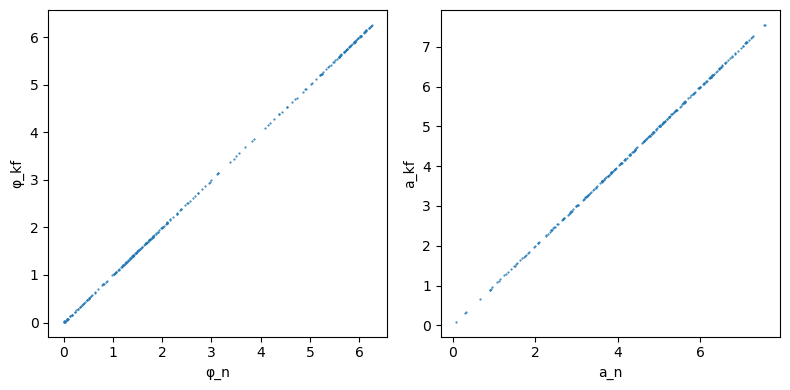

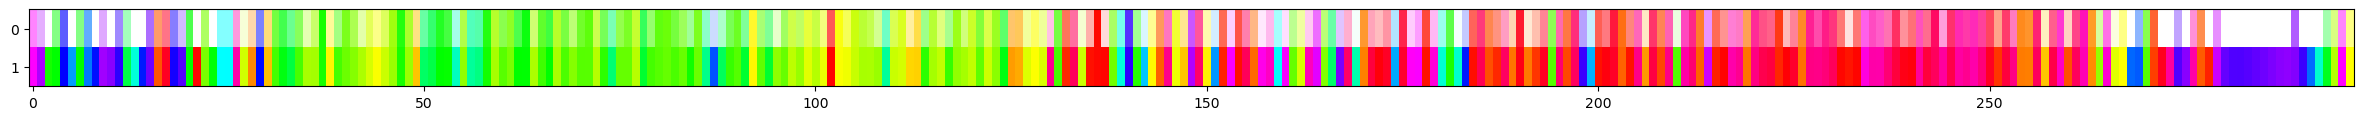

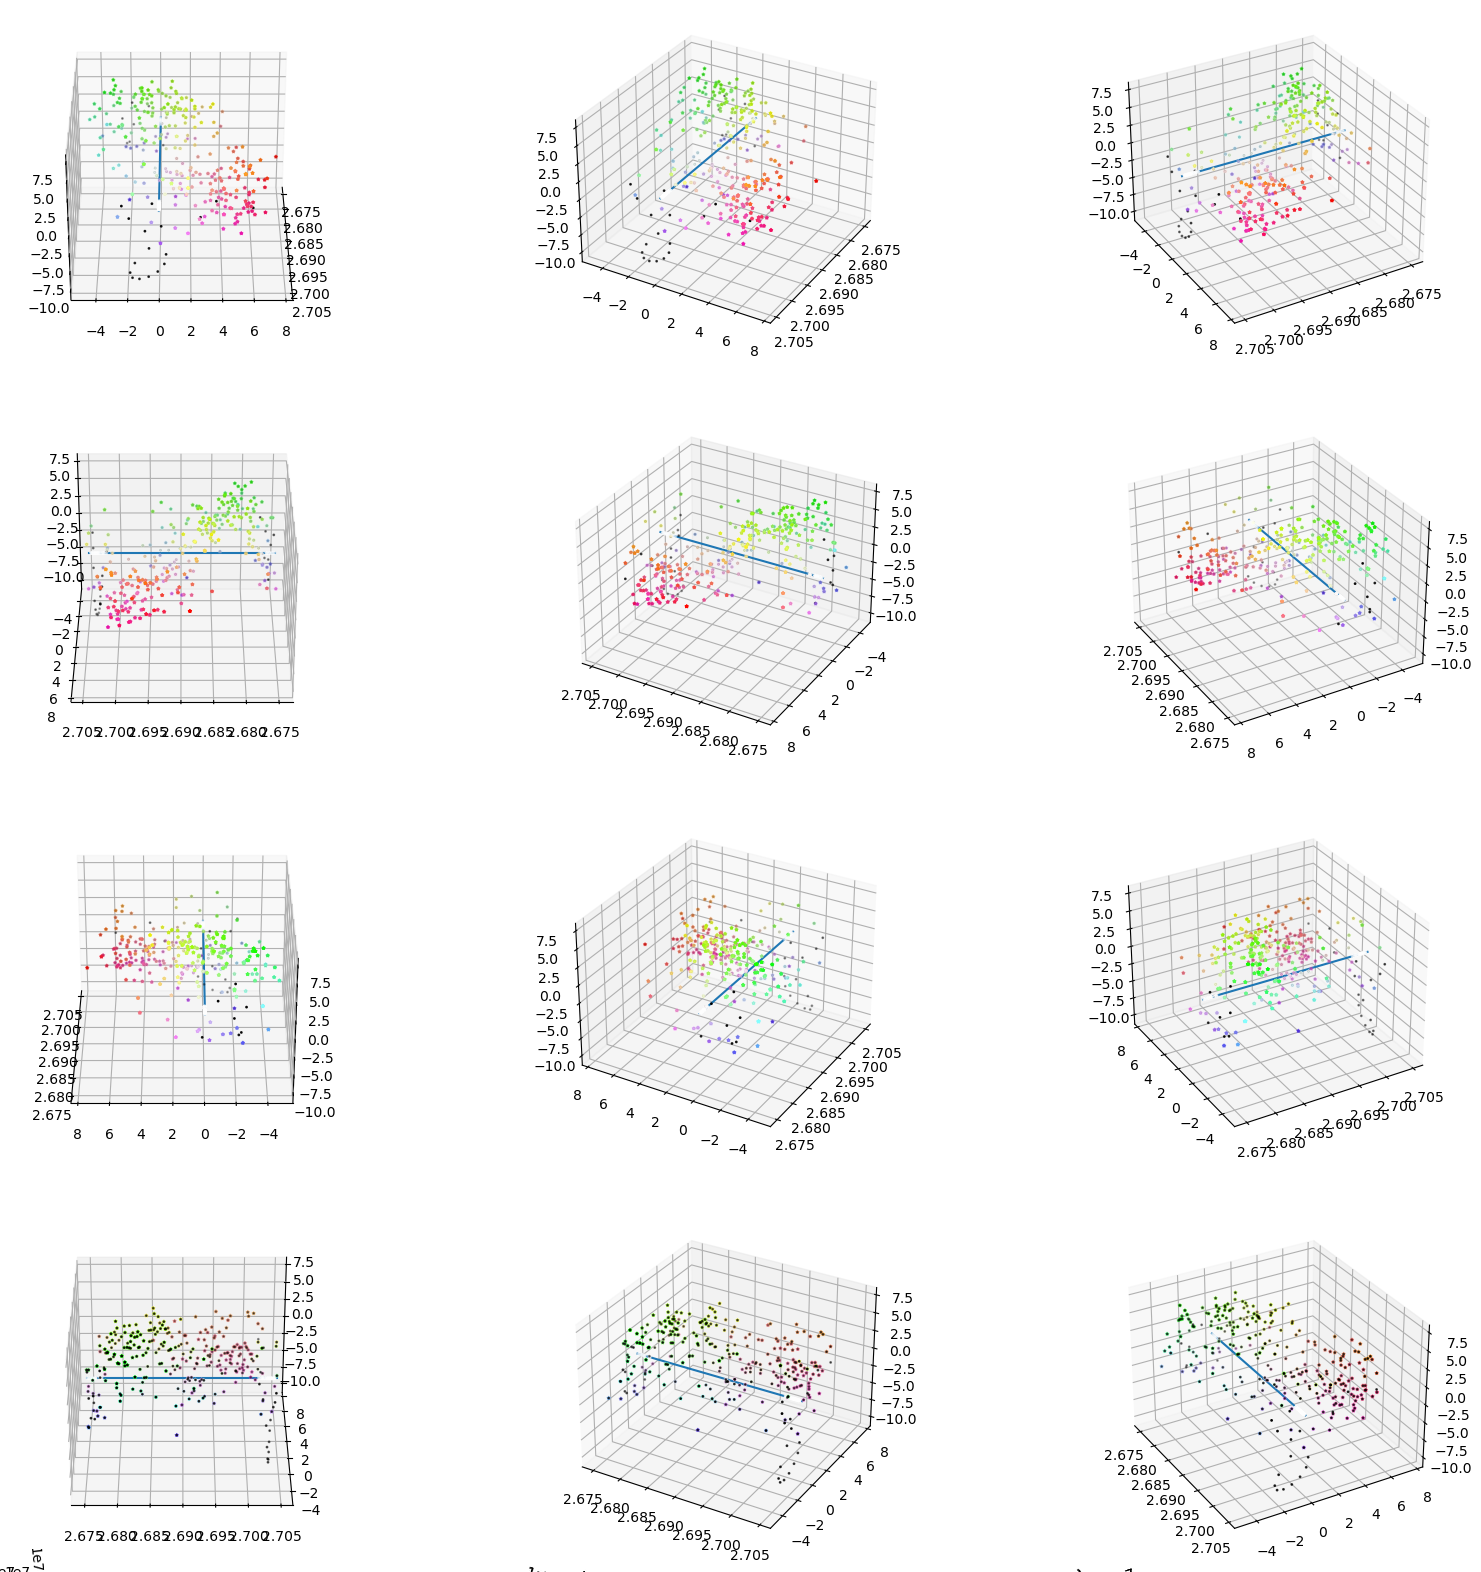

In [7]:
# Compare best with bin by bin fourrier transform

# fourier transform
f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
a_n = np.abs(f_n)
# normalize
φ_n = np.angle(f_n)
φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
# in between 0 and 2pi

# plot phase per bin
h = φ_n/(2*np.pi)
s = a_n/np.nanmax(a_n)
v = np.ones(len(x))
color_f = hsv_to_rgb_v(h,s,v)
f_n[np.isnan(f_n)] = 0

μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
a_kf = np.abs(μ_tT_best_C)
φ_kf = np.angle(μ_tT_best_C)
φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

h = φ_kf/(2*np.pi)
s = np.ones(len(x))#a_kf/a_kf.max()
v = np.ones(len(x))
color_kf = hsv_to_rgb_v(h,s,v)

fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(φ_n,φ_kf,s=1,marker='.')
plt.xlabel('φ_n')
plt.ylabel('φ_kf')

plt.subplot(122)
plt.scatter(a_n,a_kf,s=1,marker='.')
plt.xlabel('a_n')
plt.ylabel('a_kf')

fig.tight_layout()

# plot phase per bin
Φ = np.ones((2,len(x),3))
Φ[0,:] = color_f
Φ[1,:] = color_kf
fig = plt.figure(figsize=(30,1))
plt.imshow(Φ,aspect='auto',interpolation='none')

if True:
    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(0,360,30) ):
        ax = fig.add_subplot(4,3,f+1, projection='3d')
        ax.scatter(xs=x, ys=f_n.real, zs=f_n.imag,color=Φ[0,:],s=5,marker='*')
        ax.scatter(xs=x, ys=μ_tT_best_C.real, zs=μ_tT_best_C.imag,color='k',s=1,marker='o')
        #ax.plot3D(positions,f_n.real,f_n.imag,color='k',linewidth=0.5)
        #for i in range(len(positions)):
        #    ax.plot3D([positions[i],positions[i]],[f_n.real[i],μ_tT_best_C.real[i]],[f_n.imag[i],μ_tT_best_C.imag[i]],color='k',linewidth=0.5)
        #ax.plot3D(positions,μ_tT_best_C.real,μ_tT_best_C.imag,color='k',linewidth=0.5)
        ax.plot3D(x,np.zeros(len(x)),np.zeros(len(x)))
        ax.view_init(elev=30, azim=azim, roll=0)


    #plt.draw()
    #plt.pause(.5)
#plt.show()

if False:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Grab some example data and plot a basic wireframe.
    ax.plot_wireframe(x, y ,z , rstride=10, cstride=10)

    # Set the axis labels
    ax.set_xlabel('position')
    ax.set_ylabel('Re(f_n)')
    ax.set_zlabel('Im(f_n)')

    # Rotate the axes and update
    for angle in range(0, 360 + 1,20):
        # Normalize the angle to the range [-180, 180] for display
        angle_norm = (angle + 180) % 360 - 180

        # Cycle through a full rotation of elevation, then azimuth, roll, and all
        elev = azim = roll = 0
        if angle <= 360:
            elev = angle_norm
        elif angle <= 360*2:
            azim = angle_norm
        elif angle <= 360*3:
            roll = angle_norm
        else:
            elev = azim = roll = angle_norm

        # Update the axis view and title
        ax.view_init(elev, azim, roll)
        plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

        plt.draw()
        plt.pause(.001)


# Test Fourier transform 

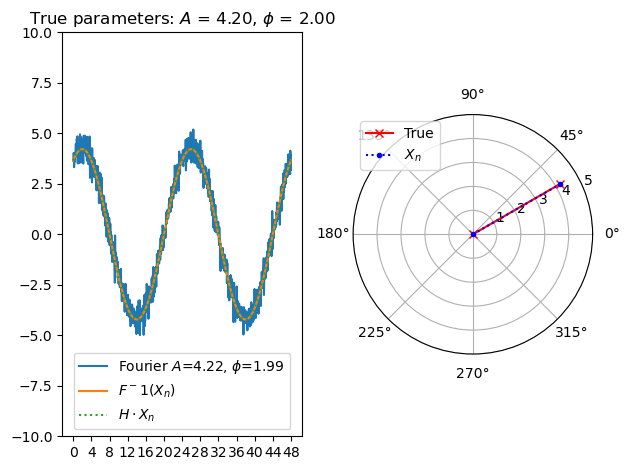

In [121]:
# Oscillation paramters
P = 24
T = np.linspace(0,48,1000)
ω = 2*np.pi/P # angular frequency
A_true = 4.2
φ_true = 2/P*(2*np.pi)

# generate data
x_t = A_true * np.cos(ω*T-φ_true) + .1*A_true*np.random.normal(0,1,len(T))

# fourier transform
X_n = 1/len(T) * np.sum( x_t * np.exp(-1j*ω*T) )
A_f_f = 2*np.sqrt(X_n.real**2 + X_n.imag**2)
#φ_f_f = np.angle(X_n)
φ_f_f = np.arctan(-X_n.imag/X_n.real)

# inverse fourier transform
x_t_recon = 2 * np.real( X_n * np.exp(1j*ω*T) )
#A_f_t = np.sqrt(x_t_recon[0]**2 + x_t_recon[1]**2)
#φ_f_t = np.arctan2(x_t_recon[1],x_t_recon[0])


H = np.zeros((len(T),2))
H[:,0] = np.cos(ω*T)
H[:,1] = -np.sin(ω*T)
H *= 2
x_t_recon_H = H @ np.array([X_n.real,X_n.imag])
#A_H = np.sqrt(x_t_recon_H[0]**2 + x_t_recon_H[1]**2)
#φ_H = np.arctan2(x_t_recon_H[1],x_t_recon_H[0])

plt.figure()
plt.subplot(121)
plt.plot(T,x_t,label=rf'Fourier $A$={A_f_f:.2f}, $\phi$={φ_f_f/(2*np.pi)*P:.2f}')
plt.plot(T,x_t_recon,label=rf'$F^{-1}(X_n)$')# $A$={A_f_t:.2f}, $\phi$={φ_f_t/(2*np.pi)*P:.2f}')
plt.plot(T,x_t_recon_H,':',label=rf'$H\cdot X_n$')# $A$={A_H:.2f}, $\phi$={φ_H/(2*np.pi)*P:.2f}')
plt.title(r'True parameters: $A$ = %.2f, $\phi$ = %.2f' % (A_true,φ_true/(2*np.pi)*P))
plt.legend(loc='lower center')
plt.ylim(-10,10)
plt.xticks(np.arange(0,48+1,4))

# plot amplitude and phase in a polar plot
ax = plt.subplot(122, projection='polar')
ax.plot([0,φ_true],[0, A_true],'r-x',label='True')
ax.plot([0,φ_f_f],[0,A_f_f],'b:.',label=r'$X_n$')
ax.legend(loc='upper left')
ax.set_rmax(5)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)

plt.tight_layout()


if False:
    plt.figure()
    plt.scatter(x_t,x_t_recon)

    c = np.linspace(-2,2,100)
    res = np.sqrt(np.mean((x_t - c[:,None]*x_t_recon)**2,1))

    def f(c):
        return np.sqrt(np.mean((x_t - c*x_t_recon)**2))

    # minimize
    from scipy.optimize import minimize
    res_min = minimize(f,0,method='Nelder-Mead',tol=1e-10).x


    plt.figure()
    plt.plot(c,res)
    plt.plot(res_min,f(res_min),'r.')
    plt.yscale('log')


In [48]:
print(X_n/len(T))

np.angle(X_n)/(2*np.pi)*P

(1.0038710335207304-1.8086244640434939j)


-4.064511993961304

In [39]:
np.angle(1+1j)/(2*np.pi)*P

3.0

In [69]:
x_t_recon

array([ 3.62836472e+00,  3.60158924e+00,  3.57424389e+00,  3.54633299e+00,
        3.51786096e+00,  3.48883231e+00,  3.45925162e+00,  3.42912359e+00,
        3.39845298e+00,  3.36724463e+00,  3.33550349e+00,  3.30323459e+00,
        3.27044301e+00,  3.23713397e+00,  3.20331272e+00,  3.16898461e+00,
        3.13415509e+00,  3.09882965e+00,  3.06301389e+00,  3.02671348e+00,
        2.98993415e+00,  2.95268174e+00,  2.91496213e+00,  2.87678129e+00,
        2.83814526e+00,  2.79906017e+00,  2.75953218e+00,  2.71956755e+00,
        2.67917262e+00,  2.63835376e+00,  2.59711744e+00,  2.55547019e+00,
        2.51341859e+00,  2.47096930e+00,  2.42812903e+00,  2.38490457e+00,
        2.34130274e+00,  2.29733046e+00,  2.25299467e+00,  2.20830240e+00,
        2.16326071e+00,  2.11787673e+00,  2.07215765e+00,  2.02611070e+00,
        1.97974315e+00,  1.93306236e+00,  1.88607570e+00,  1.83879061e+00,
        1.79121458e+00,  1.74335512e+00,  1.69521982e+00,  1.64681628e+00,
        1.59815218e+00,  